# **Assignmnet 02**


#**Libraries and Dataset**


In [1]:
import numpy as np
import pandas as pd

import torch
from torch import nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset

import torchvision
from torch.utils.data import TensorDataset,DataLoader
from torch import optim
import torch.utils.data as tdata
import os
import cv2
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report

from sklearn import model_selection
from sklearn.metrics import accuracy_score, confusion_matrix, precision_score, recall_score

In [2]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import OneHotEncoder

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [4]:
df = pd.read_csv("/content/drive/MyDrive/Dataset.csv")
df

,Text,Sentiment
0,Kickers on my watchlist XIDE TIT SOQ PNK CPW B...,1
1,user: AAP MOVIE. 55% return for the FEA/GEED i...,1
2,user I'd be afraid to short AMZN - they are lo...,1
3,MNTA Over 12.00,1
4,OI Over 21.37,1
...,...,...
5786,Industry body CII said #discoms are likely to ...,-1
5787,"#Gold prices slip below Rs 46,000 as #investor...",-1
5788,Workers at Bajaj Auto have agreed to a 10% wag...,1
5789,"#Sharemarket LIVE: Sensex off day’s high, up 6...",1


In [5]:
df.describe()

,Sentiment
count,5791.000000
mean,0.272664
std,0.962192
min,-1.000000
25%,-1.000000
50%,1.000000
75%,1.000000
max,1.000000


In [6]:
positives = df['Sentiment'][df.Sentiment == 1 ]
negatives = df['Sentiment'][df.Sentiment == -1 ]

print('Total length:         {}'.format(df.shape[0]))
print('positve  sentences:   {}'.format(len(positives)))
print('negative  sentences : {}'.format(len(negatives)))

Total length:         5791
positve  sentences:   3685
negative  sentences : 2106


/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


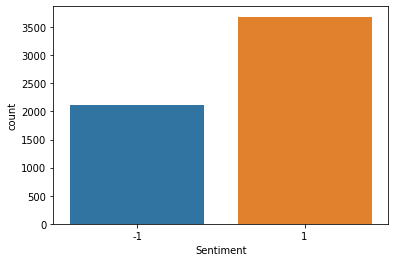

In [7]:
import seaborn as sns
sns.countplot(df['Sentiment'])

#**Pre-processing Dataset**

In [8]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cpu')

In [9]:
#stop word removal
import nltk
nltk.download("stopwords")

from nltk.corpus import stopwords
", ".join(stopwords.words('english'))

STOPWORDS = set(stopwords.words('english'))
def remove_stopwords(text):
    """custom function to remove the stopwords"""
    return " ".join([word for word in str(text).split() if word not in STOPWORDS])

df["Text"] = df["Text"].apply(lambda text: remove_stopwords(text))
df.head()

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


,Text,Sentiment
0,Kickers watchlist XIDE TIT SOQ PNK CPW BPZ AJ ...,1
1,user: AAP MOVIE. 55% return FEA/GEED indicator...,1
2,user I'd afraid short AMZN - looking like near...,1
3,MNTA Over 12.00,1
4,OI Over 21.37,1


In [10]:
#Stemming
from nltk.stem.porter import PorterStemmer

stemmer = PorterStemmer()
def stem_words(text):
    return " ".join([stemmer.stem(word) for word in text.split()])

df["Text"] = df["Text"].apply(lambda text: stem_words(text))
df.head()

,Text,Sentiment
0,kicker watchlist xide tit soq pnk cpw bpz AJ t...,1
1,user: aap movie. 55% return fea/ge indic 15 tr...,1
2,user i'd afraid short amzn - look like near-mo...,1
3,mnta over 12.00,1
4,OI over 21.37,1


In [11]:
seed = 170204030
torch.manual_seed(seed)

# **Bag of words**

In [12]:
from sklearn.feature_extraction.text import CountVectorizer
class Sequences(Dataset):
    def __init__(self, data):
        self.vectorizer = CountVectorizer()
        self.sequences= self.vectorizer.fit_transform(data.Text.tolist())
        self.labels=data.Sentiment.tolist()

        self.token2idx=self.vectorizer.vocabulary_
        self.idx2token={idx: token for token, idx in self.token2idx.items()}
    def __getitem__(self, i):
        return self.sequences[i, :].toarray(), self.labels[i]
    
    def __len__(self):
        return self.sequences.shape[0]

In [13]:
df.columns=["Text", "Sentiment"]
df_train=df.head(5000)
df_test=df.tail(790)

dataset=Sequences(df_train)
train_loader=DataLoader(dataset,batch_size=5000)

In [14]:
class NeuralNetwork(nn.Module):
    def __init__(self, vocab_size,hidden1,hidden2):
        super().__init__()
        self.linear_1=nn.Linear(vocab_size, hidden1)
        self.relu1=nn.ReLU()

        self.linear_2=nn.Linear(hidden1, hidden2)
        self.relu2=nn.ReLU()

        self.linear_out=nn.Linear(hidden2,1)
    def forward(self, inputs):
        out= self.linear_1(inputs.squeeze(1).float())
        out=self.relu1(out)
        
        out=self.linear_2(out)
        out=self.relu2(out)
        logits = self.linear_out(out)
        return F.log_softmax(logits, dim=1)

NNmodel= NeuralNetwork(len(dataset.token2idx), 512, 512)
NNmodel

optimizer=torch.optim.Adam(NNmodel.parameters(), lr=0.1)
criterion=nn.BCEWithLogitsLoss()

In [28]:
EPOCHS = 20
Avg_loss = 0
epoch_loss =[]

for epoch in range(EPOCHS):
    for inputs,target in train_loader:
        target=target.view(5000, -1)
        NNmodel.zero_grad()
        logs = NNmodel(inputs)
        loss = criterion(logs,target.float())
        loss.backward()
        optimizer.step()
        
    epoch_loss.append(loss.item())
    Avg_loss += loss.item()
    print('epoch: {}. Loss: {}'.format(epoch+1, loss.item()))
    
print('\nAverage Loss: ',Avg_loss/EPOCHS)

epoch: 1. Loss: 0.6931472420692444
epoch: 2. Loss: 0.6931472420692444
epoch: 3. Loss: 0.6931472420692444
epoch: 4. Loss: 0.6931472420692444
epoch: 5. Loss: 0.6931472420692444
epoch: 6. Loss: 0.6931472420692444
epoch: 7. Loss: 0.6931472420692444
epoch: 8. Loss: 0.6931472420692444
epoch: 9. Loss: 0.6931472420692444
epoch: 10. Loss: 0.6931472420692444
epoch: 11. Loss: 0.6931472420692444
epoch: 12. Loss: 0.6931472420692444
epoch: 13. Loss: 0.6931472420692444
epoch: 14. Loss: 0.6931472420692444
epoch: 15. Loss: 0.6931472420692444
epoch: 16. Loss: 0.6931472420692444
epoch: 17. Loss: 0.6931472420692444
epoch: 18. Loss: 0.6931472420692444
epoch: 19. Loss: 0.6931472420692444
epoch: 20. Loss: 0.6931472420692444

Average Loss:  0.6931472420692444


In [17]:
from sklearn.metrics import accuracy_score

def predict_sentiment(text):
    test_vector=torch.LongTensor(dataset.vectorizer.transform([text]).toarray())
    output= NNmodel(test_vector.float())
    prediction=torch.sigmoid(output).item()
    if prediction>0.5:
        return 1
    else:
        return -1

pred_labels=[]
sentences=list(df_test['Text'])
labels=df_test['Sentiment']
#print(sentences)
for sentence in sentences:
    pred_labels.append(predict_sentiment(sentence))
#accuracy
accuracy=accuracy_score(labels,pred_labels)
accuracy=accuracy*100
print('Accuracy: %f'% accuracy)

Accuracy: 57.848101


Accuracy:  57.848101265822784
Recall 0.000
precision 0.000
f1_score 0.000

              precision    recall  f1-score   support

          -1       0.58      1.00      0.73       457
           1       0.00      0.00      0.00       333

    accuracy                           0.58       790
   macro avg       0.29      0.50      0.37       790
weighted avg       0.33      0.58      0.42       790



/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: Undefine

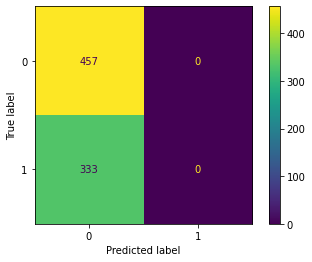

In [18]:
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score
from sklearn import metrics

conf = metrics.confusion_matrix(labels, pred_labels)
metrics.ConfusionMatrixDisplay(conf).plot()
print ('Accuracy: ', metrics.accuracy_score(labels, pred_labels)*100)

recall=recall_score(labels,pred_labels,average="binary")
recall = recall*100
print('Recall %.3f'%recall)

precision=precision_score(labels,pred_labels,average="binary")
precision = precision*100
print('precision %.3f'%precision)

f1=f1_score(labels,pred_labels,average="binary")
f1 = f1*100
print('f1_score %.3f'%f1)
print()
print (metrics.classification_report(labels, pred_labels))

plt.show()

# **TF-IDF**

In [19]:
class Sequences(Dataset):
    def __init__(self, data):
        self.vectorizer = TfidfVectorizer()
        self.sequences= self.vectorizer.fit_transform(data.Text.tolist())
        self.labels=data.Sentiment.tolist()

        self.token2idx=self.vectorizer.vocabulary_
        self.idx2token={idx: token for token, idx in self.token2idx.items()}
    def __getitem__(self, i):
        return self.sequences[i, :].toarray(), self.labels[i]
    
    def __len__(self):
        return self.sequences.shape[0]

In [20]:
#batch_size = 10
df.columns=["Text", "Sentiment"]
df_train=df.head(5000)
df_test=df.tail(790)

dataset=Sequences(df_train)
train_loader=DataLoader(dataset,batch_size=5000)

In [21]:
class NeuralNetwork(nn.Module):
    def __init__(self, vocab_size,hidden1,hidden2):
        super().__init__()
        self.linear_1=nn.Linear(vocab_size, hidden1)
        self.relu1=nn.ReLU()

        self.linear_2=nn.Linear(hidden1, hidden2)
        self.relu2=nn.ReLU()

        self.linear_out=nn.Linear(hidden2,1)
    def forward(self, inputs):
        out= self.linear_1(inputs.squeeze(1).float())
        out=self.relu1(out)
        
        out=self.linear_2(out)
        out=self.relu2(out)
        logits = self.linear_out(out)
        return F.log_softmax(logits, dim=1)

NNmodel= NeuralNetwork(len(dataset.token2idx), 512, 512)
NNmodel

optimizer=torch.optim.Adam(NNmodel.parameters(), lr=0.1)
criterion=nn.BCEWithLogitsLoss()

In [22]:
EPOCHS = 20
Avg_loss = 0
epoch_loss =[]

for epoch in range(EPOCHS):
    for inputs,target in train_loader:
        target=target.view(5000, -1)
        optimizer.zero_grad()
        logs = NNmodel(inputs)
        loss = criterion(logs,target.float())
        loss.backward()
        optimizer.step()
        
    epoch_loss.append(loss.item())
    Avg_loss += loss.item()
    print('epoch: {}. Loss: {}'.format(epoch+1, loss.item()))
    
print('\nAverage Loss: ',Avg_loss/EPOCHS)

epoch: 1. Loss: 0.6931472420692444
epoch: 2. Loss: 0.6931472420692444
epoch: 3. Loss: 0.6931472420692444
epoch: 4. Loss: 0.6931472420692444
epoch: 5. Loss: 0.6931472420692444
epoch: 6. Loss: 0.6931472420692444
epoch: 7. Loss: 0.6931472420692444
epoch: 8. Loss: 0.6931472420692444
epoch: 9. Loss: 0.6931472420692444
epoch: 10. Loss: 0.6931472420692444
epoch: 11. Loss: 0.6931472420692444
epoch: 12. Loss: 0.6931472420692444
epoch: 13. Loss: 0.6931472420692444
epoch: 14. Loss: 0.6931472420692444
epoch: 15. Loss: 0.6931472420692444
epoch: 16. Loss: 0.6931472420692444
epoch: 17. Loss: 0.6931472420692444
epoch: 18. Loss: 0.6931472420692444
epoch: 19. Loss: 0.6931472420692444
epoch: 20. Loss: 0.6931472420692444

Average Loss:  0.6931472420692444


In [24]:
from sklearn.metrics import accuracy_score

def predict_sentiment(text):
    test_vector=torch.LongTensor(dataset.vectorizer.transform([text]).toarray())
    output= NNmodel(test_vector.float())
    prediction=torch.sigmoid(output).item()
    if prediction>0.5:
        return 1
    else:
        return -1

pred_labels=[]
sentences=list(df_test['Text'])
labels=df_test['Sentiment']
#print(sentences)
for sentence in sentences:
    pred_labels.append(predict_sentiment(sentence))
#accuracy
accuracy=accuracy_score(labels,pred_labels)
accuracy=accuracy*100
print('Accuracy: %f'% accuracy)

Accuracy: 57.848101


Accuracy:  57.848101265822784
Recall 0.000
precision 0.000
f1_score 0.000

              precision    recall  f1-score   support

          -1       0.58      1.00      0.73       457
           1       0.00      0.00      0.00       333

    accuracy                           0.58       790
   macro avg       0.29      0.50      0.37       790
weighted avg       0.33      0.58      0.42       790



/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: Undefine

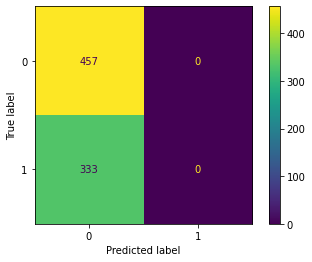

In [51]:
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score
from sklearn import metrics

conf = metrics.confusion_matrix(labels, pred_labels)
metrics.ConfusionMatrixDisplay(conf).plot()
print ('Accuracy: ', metrics.accuracy_score(labels, pred_labels)*100)

recall=recall_score(labels,pred_labels,average="binary")
recall = recall*100
print('Recall %.3f'%recall)

precision=precision_score(labels,pred_labels,average="binary")
precision = precision*100
print('precision %.3f'%precision)

f1=f1_score(labels,pred_labels,average="binary")
f1 = f1*100
print('f1_score %.3f'%f1)
print()
print (metrics.classification_report(labels, pred_labels))

plt.show()

# **One hot embedding using CNN**

In [29]:
from sklearn.model_selection import train_test_split
from keras.preprocessing.sequence import pad_sequences
from keras.preprocessing.text import Tokenizer

df = df.sample(frac = 1)
x = df['Text'].values
y = df['Sentiment'].values
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.20, random_state=seed)

tokenizer = Tokenizer()
tokenizer.fit_on_texts(x_train)

data_train = pad_sequences(tokenizer.texts_to_sequences(x_train), padding='post', maxlen=200)
data_test = pad_sequences(tokenizer.texts_to_sequences(x_test), padding='post', maxlen=200)

In [30]:
from keras.models import Sequential
from keras import layers 

v_size = len(tokenizer.word_index)+1
embedding_dim = 200

CNNmodel = Sequential()
CNNmodel.add(layers.Embedding(v_size, embedding_dim, input_length=200))
CNNmodel.add(layers.Conv1D(filters=512, kernel_size=2, activation='relu'))
CNNmodel.add(layers.MaxPooling1D(pool_size=2))

CNNmodel.add(layers.Conv1D(filters=256, kernel_size=3, activation='relu'))
CNNmodel.add(layers.MaxPooling1D(pool_size=2))

CNNmodel.add(layers.Conv1D(filters=128, kernel_size=4, activation='relu'))
CNNmodel.add(layers.GlobalMaxPooling1D())

CNNmodel.add(layers.Flatten())
CNNmodel.add(layers.Dense(64, activation='relu'))
CNNmodel.add(layers.Dense(1, activation='sigmoid'))

CNNmodel.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])

In [31]:
EPOCHS = 20
history = CNNmodel.fit(data_train, y_train,
                    epochs=EPOCHS,
                    verbose=True,
                    validation_data=(data_test, y_test),
                    batch_size=10)
loss, accuracy = CNNmodel.evaluate(data_train, y_train, verbose=False)
print("Training Accuracy: {:.3f}".format(accuracy))
loss, accuracy = CNNmodel.evaluate(data_test, y_test, verbose=False)
print("Testing Accuracy:  {:.3f}".format(accuracy))

Epoch 1/20
464/464 [==============================] - 82s 170ms/step - loss: -2240447.0000 - accuracy: 0.1967 - val_loss: -15095467.0000 - val_accuracy: 0.2752
Epoch 2/20
464/464 [==============================] - 77s 166ms/step - loss: -1478038016.0000 - accuracy: 0.2342 - val_loss: -3844878848.0000 - val_accuracy: 0.2916
Epoch 3/20
464/464 [==============================] - 77s 167ms/step - loss: -37392789504.0000 - accuracy: 0.2580 - val_loss: -53761974272.0000 - val_accuracy: 0.0000e+00
Epoch 4/20
464/464 [==============================] - 76s 164ms/step - loss: -340536131584.0000 - accuracy: 0.2563 - val_loss: -385796243456.0000 - val_accuracy: 0.2545
Epoch 5/20
464/464 [==============================] - 76s 164ms/step - loss: -1553950048256.0000 - accuracy: 0.2604 - val_loss: -1391538339840.0000 - val_accuracy: 0.2269
Epoch 6/20
464/464 [==============================] - 75s 163ms/step - loss: -5014674735104.0000 - accuracy: 0.2640 - val_loss: -3931011022848.0000 - val_accuracy: 

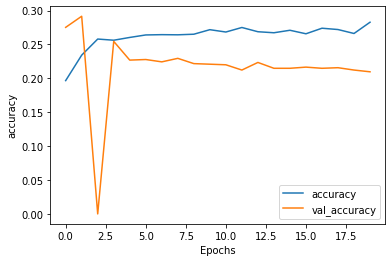

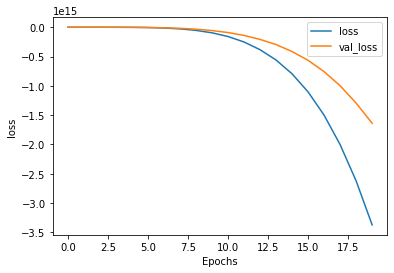

In [38]:
import matplotlib.pyplot as plt
def plot_graphs(history, string):
  plt.plot(history.history[string])
  plt.plot(history.history['val_'+string])
  plt.xlabel("Epochs")
  plt.ylabel(string)
  plt.legend([string, 'val_'+string])
  plt.show()

plot_graphs(history, 'accuracy')
plot_graphs(history, 'loss')